In [1]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
stan_code = """

data {
    int<lower=1> N;
    matrix[N, 3] x;
    vector[N] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

model {
    sigma ~ inv_gamma(0.3, 0.6);
    alpha ~ normal(0, 5);
    beta ~ normal(0,1);

    for (n in 1:N) {
        y[n] ~ normal(alpha + beta' * (x[n]'), sigma);
    }
}

"""

In [44]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

# Standardize the data in these columns

for col in key_param_df:
    key_param_df[col] = (key_param_df[col] - key_param_df[col].mean())/(key_param_df[col].std())

# Also standardize the charges
insurance_data["charges"] = (insurance_data['charges'] - insurance_data['charges'].mean())/(insurance_data['charges'].std())


parameter_vals = key_param_df.values
charges_vals = insurance_data["charges"].values

num_rows = parameter_vals.shape[0]


training_data_params = parameter_vals[:(num_rows//2), :]
testing_data_params = parameter_vals[:(num_rows//2), :]

training_data_charges = charges_vals[:(num_rows//2)]
training_data_charges = charges_vals[(num_rows//2):]

print(training_data_params)

[[-1.4382265  -0.45315057 -0.90827406]
 [-1.50940108  0.50943062 -0.07873775]
 [-0.7976553   0.38316358  1.58033487]
 ...
 [ 0.69701083 -0.32196403 -0.07873775]
 [ 0.05643963  0.34626737  0.75079856]
 [ 1.62228035  0.22164016 -0.90827406]]


In [45]:
data_dict = {
    'N': training_data_charges.shape[0],
    #'x': np.ndarray(key_param_df.values, dtype=float)
    'x': training_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [46]:
fit = model.sample(num_chains=4, num_samples=100, num_warmup=50)

Sampling:   0%
Sampling:  25% (150/600)
Sampling:  50% (300/600)
Sampling:  75% (450/600)
Sampling: 100% (600/600)
Sampling: 100% (600/600), done.
Messages received during sampling:
  Gradient evaluation took 0.000329 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.29 seconds.
  Adjust your expectations accordingly!
           three stages of adaptation as currently configured.
           Reducing each adaptation stage to 15%/75%/10% of
           the given number of warmup iterations:
             init_buffer = 7
             adapt_window = 38
             term_buffer = 5
  Gradient evaluation took 0.000424 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.24 seconds.
  Adjust your expectations accordingly!
           three stages of adaptation as currently configured.
           Reducing each adaptation stage to 15%/75%/10% of
           the given number of warmup iterations:
             init_buffer = 7
             adapt_w

In [47]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.995,0.028,0.944,1.046,0.001,0.001,496.0,370.0,1.01
alpha,-0.012,0.038,-0.076,0.059,0.002,0.002,415.0,318.0,1.00
beta[0],0.022,0.037,-0.059,0.080,0.002,0.002,416.0,206.0,1.02
beta[1],-0.016,0.043,-0.100,0.059,0.002,0.002,471.0,294.0,1.01
beta[2],-0.079,0.039,-0.153,-0.011,0.002,0.002,431.0,271.0,1.00


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>]], dtype=object)

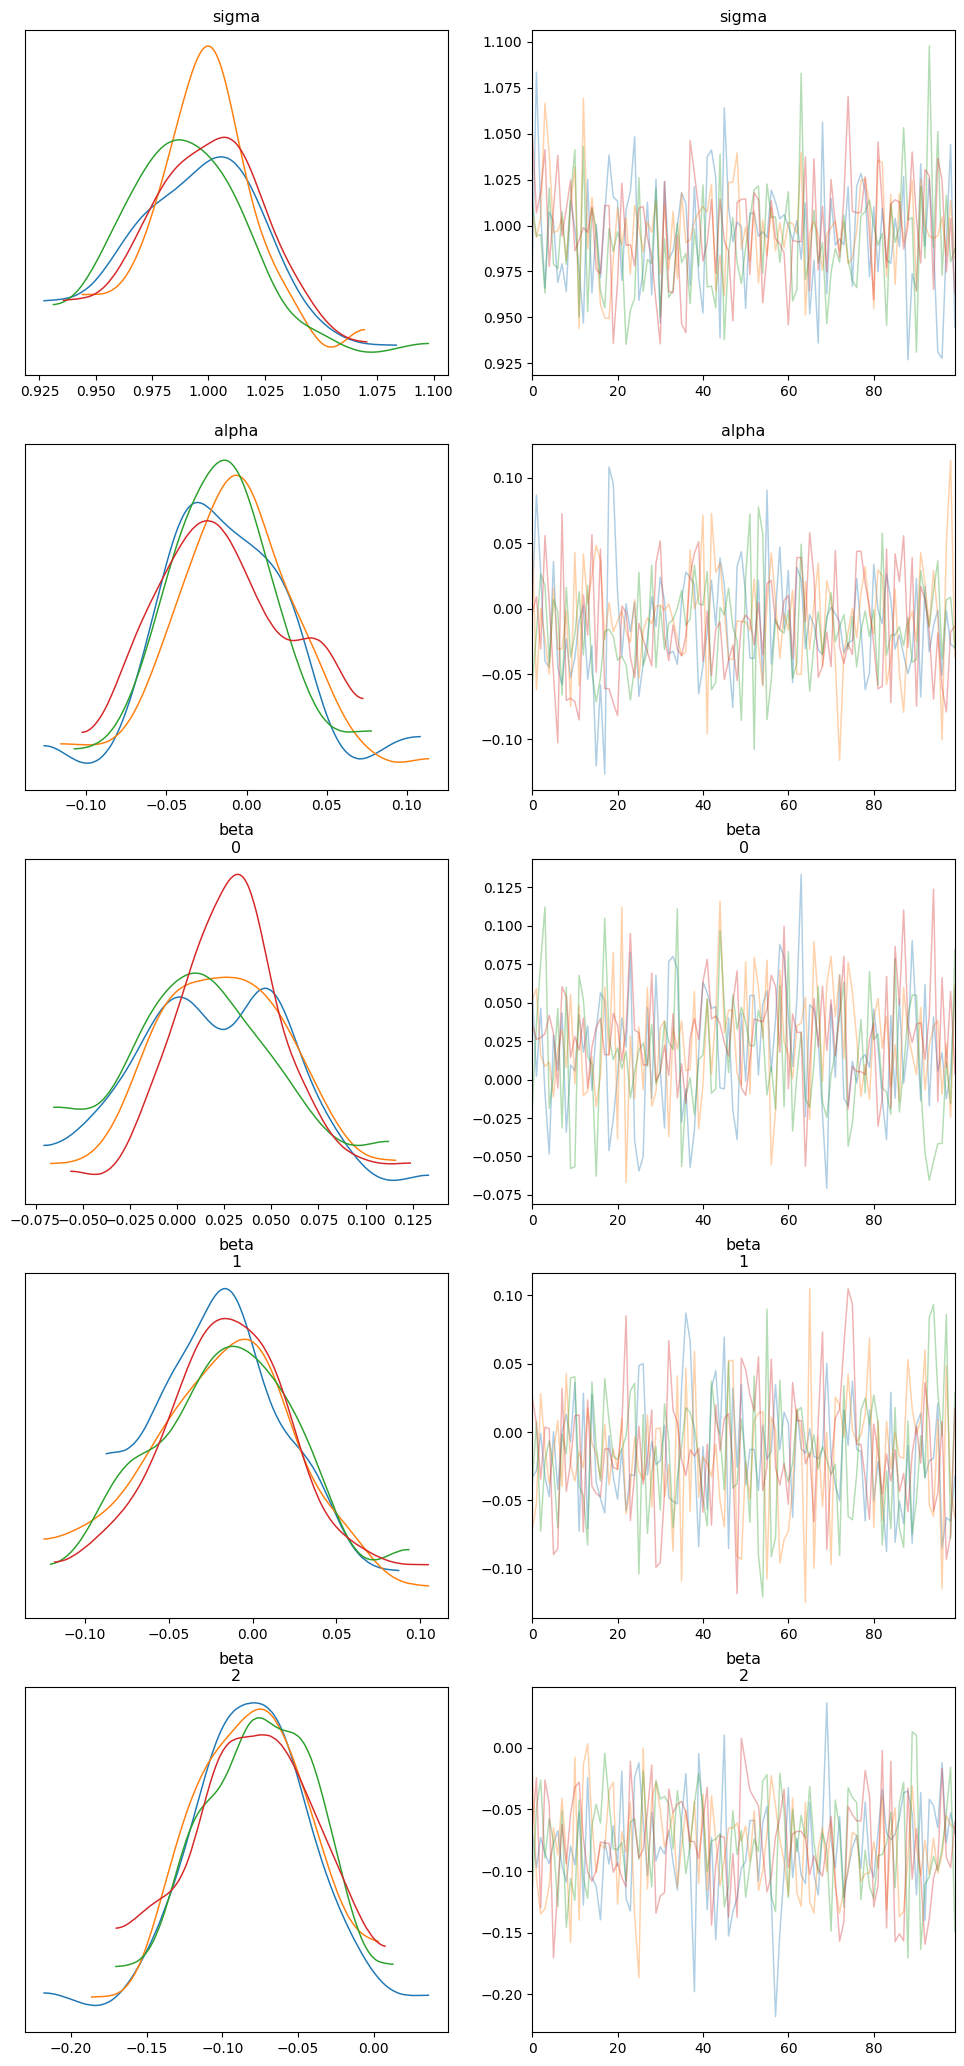

In [48]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

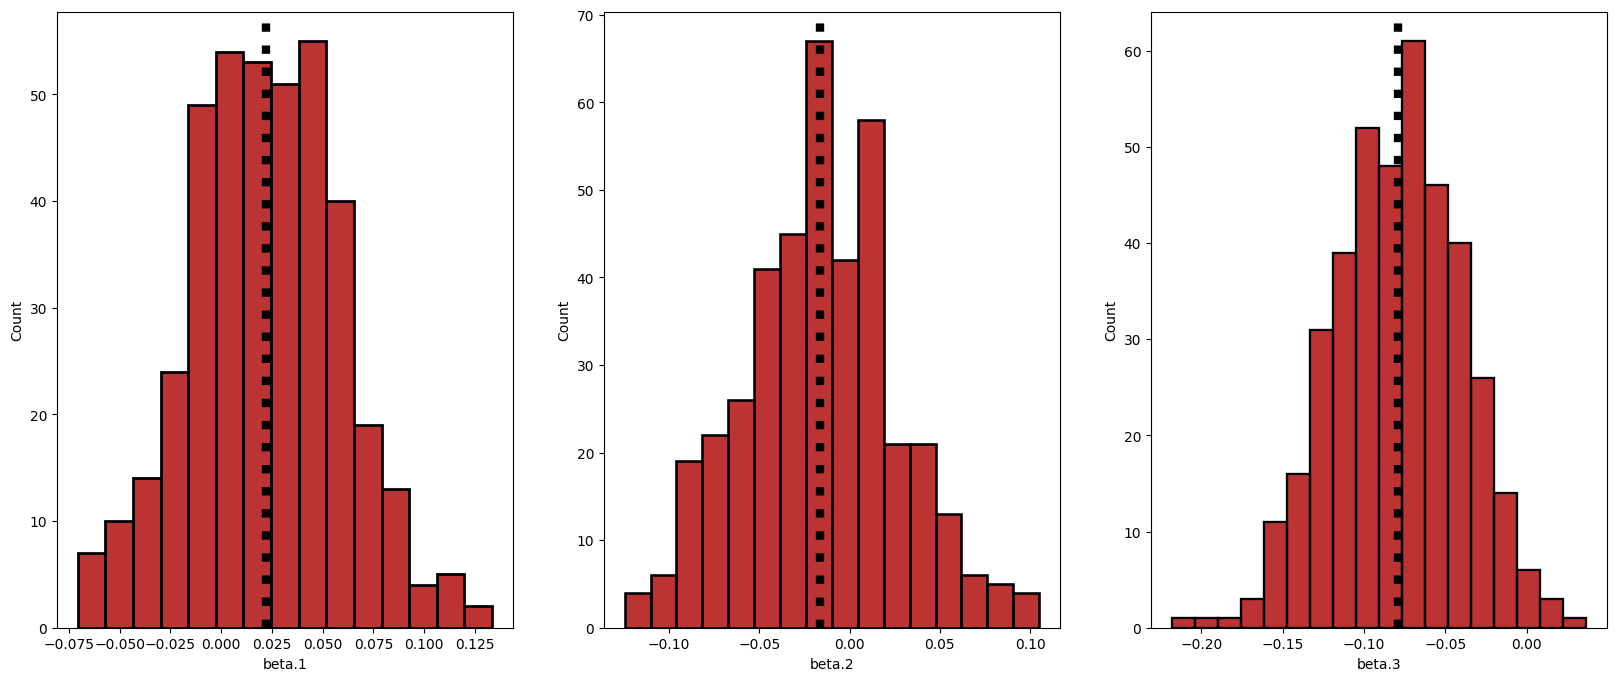

In [49]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)